In [ ]:
# Cell 1: Install libraries
# !pip install torch torch-geometric
# print("✅ Installation complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
✅ Installation complete!


In [ ]:
# Cell 2: Import libraries and load data
import json
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np

# Load your JSON file
print("📂 Loading JSON file...")
import os
if os.path.exists('gcn-graph-with-neighbors.json'):
    with open('gcn-graph-with-neighbors.json', 'r') as f:
        graph_data = json.load(f)
else:
    # Fallback if testing manually
    with open('gcn-graph-with-neighbors-2025-11-03.json', 'r') as f:
        graph_data = json.load(f)

print(f"✅ Loaded successfully!")
print(f"   Total nodes: {len(graph_data['nodes'])}")
print(f"   Total edges: {len(graph_data['edges'])}")
print(f"   Risk threshold: {graph_data['metadata']['risk_threshold']:.4f}")

📂 Loading JSON file...
✅ Loaded successfully!
   Total nodes: 63
   Total edges: 140
   Risk threshold: 0.2682


In [ ]:
# Cell 3: IMPROVED Hybrid Labeling Strategy

threshold = graph_data['metadata']['risk_threshold']

print(f"🏷️  IMPROVED HYBRID LABELING STRATEGY")
print(f"   Combining manual expertise + micro-score thresholds\n")
print(f"   Dynamic threshold: {threshold:.4f}\n")

# ============================================
# PART 1: MANUAL LABELS (High Confidence)
# ============================================

manual_fraud = {
    'BinanceWallet',
    '0xc8ebccC5F5689Fa8659d83713341e5aD19349448',
    '0x136D4b662BbD1080Cfe4445B0fA213864435B7f1',
    '0xA1E4380A3B1f749673E270229993eE55F35663b4',  # Score: 0.414 + part of cycle
    '0xc9D4035F4A9226D50f79b73Aafb5d874a1B6537e',  # Score: 0.453 + high activity
}

manual_clean = {
    '0x15e34A8324164Ef0890471F6f527451F7a22CF12',  # Score: 0.158
    '0x1C68a66138783A63c98cc675a9eC77AF4598D35e',  # Score: 0.229
    '0xd65F9b9AA7BeCfd1481Bdd7E22527ca0900B7bc8',  # Score: 0.231
    '0x5C12A8e43Faf884521C2454f39560e6C265a68C8',  # Score: 0.240
    '0x07dc8c8B927adbEDfa8f5d639b4352351F2F36d2',  # Score: 0.236
    # All of these have micro-score < 0.25 and simple patterns
}

# --- FIX: Filter out IDs that the frontend didn't send ---
existing_ids = set(node['id'] for node in graph_data['nodes'])

# Only keep manual labels if they actually exist in the current data
manual_fraud = {nid for nid in manual_fraud if nid in existing_ids}
manual_clean = {nid for nid in manual_clean if nid in existing_ids}

print("📌 MANUAL LABELS:")
print(f"   Manual FRAUD: {len(manual_fraud)} wallets")
print(f"   Manual CLEAN: {len(manual_clean)} wallets")

# ============================================
# PART 2: IMPROVED THRESHOLD-BASED LABELS
# ============================================

# More reasonable thresholds
FRAUD_THRESHOLD_HIGH = threshold * 1.5   # ≥0.429 (was too high at 0.483)
CLEAN_THRESHOLD_LOW = threshold * 0.8205    # ≤0.215 (was too low at 0.201)

print(f"\n📊 IMPROVED THRESHOLD RULES:")
print(f"   Auto-FRAUD if micro-score ≥ {FRAUD_THRESHOLD_HIGH:.3f}")
print(f"   Auto-CLEAN if micro-score ≤ {CLEAN_THRESHOLD_LOW:.3f}")
print(f"   UNKNOWN if in between\n")

threshold_fraud = set()
threshold_clean = set()

for node in graph_data['nodes']:
    node_id = node['id']
    micro_score = node['features']['micro_score']
    degree = node['features']['degree']
    in_degree = node['features']['in_degree']
    out_degree = node['features']['out_degree']

    # Skip if already manually labeled
    if node_id in manual_fraud or node_id in manual_clean:
        continue

    # ==========================================
    # FRAUD DETECTION (More Lenient)
    # ==========================================
    if micro_score >= FRAUD_THRESHOLD_HIGH:
        threshold_fraud.add(node_id)
        continue

    # ==========================================
    # CLEAN DETECTION (Improved Logic)
    # ==========================================
    if micro_score <= CLEAN_THRESHOLD_LOW:

        # Strategy 1: Very low degree (simple users)
        if degree <= 2:
            threshold_clean.add(node_id)
            continue

        # Strategy 2: Only receives (no outgoing = likely exchange deposit address)
        if out_degree == 0 and in_degree <= 4:
            threshold_clean.add(node_id)
            continue

        # Strategy 3: Balanced in/out with low activity
        if degree <= 4 and abs(in_degree - out_degree) <= 2:
            # NOT in tight cycle (sends back to same address)
            is_tight_cycle = False
            for edge1 in graph_data['edges']:
                if edge1['source'] == node_id:
                    # Does the target send back?
                    for edge2 in graph_data['edges']:
                        if edge2['source'] == edge1['target'] and edge2['target'] == node_id:
                            is_tight_cycle = True
                            break
                if is_tight_cycle:
                    break

            if not is_tight_cycle:
                threshold_clean.add(node_id)
                continue

print(f"📊 THRESHOLD-BASED LABELS:")
print(f"   Threshold FRAUD: {len(threshold_fraud)} wallets")
print(f"   Threshold CLEAN: {len(threshold_clean)} wallets")

# ============================================
# PART 3: COMBINE BOTH STRATEGIES
# ============================================

fraud_nodes = list(manual_fraud.union(threshold_fraud))
clean_nodes = list(manual_clean.union(threshold_clean))

unknown_nodes = []
for node in graph_data['nodes']:
    if node['id'] not in fraud_nodes and node['id'] not in clean_nodes:
        unknown_nodes.append(node['id'])

# Apply final labels
for node in graph_data['nodes']:
    if node['id'] in fraud_nodes:
        node['label'] = 1  # FRAUD
    elif node['id'] in clean_nodes:
        node['label'] = 0  # CLEAN
    else:
        node['label'] = -1  # UNKNOWN

# ============================================
# PART 4: QUALITY CHECK WITH RECOMMENDATIONS
# ============================================

print(f"\n" + "="*70)
print("📊 FINAL LABELING SUMMARY")
print("="*70)

total = len(graph_data['nodes'])
print(f"\n🔴 FRAUD nodes: {len(fraud_nodes)} ({len(fraud_nodes)/total*100:.1f}%)")
print(f"   - Manual: {len(manual_fraud)}")
print(f"   - Threshold: {len(threshold_fraud)}")

print(f"\n🟢 CLEAN nodes: {len(clean_nodes)} ({len(clean_nodes)/total*100:.1f}%)")
print(f"   - Manual: {len(manual_clean)}")
print(f"   - Threshold: {len(threshold_clean)}")

print(f"\n⚪ UNKNOWN nodes: {len(unknown_nodes)} ({len(unknown_nodes)/total*100:.1f}%)")
print(f"   (GCN will predict these)")

# Check for balance
if len(clean_nodes) == 0:
    print(f"\n⚠️  CRITICAL: No clean examples!")
    print(f"   → Add these to manual_clean:")
    # Suggest cleanest nodes
    sorted_nodes = sorted(graph_data['nodes'], key=lambda n: n['features']['micro_score'])
    for node in sorted_nodes[:5]:
        if node['id'] not in fraud_nodes:
            print(f"      '{node['id']}',  # Score: {node['features']['micro_score']:.3f}")

elif len(fraud_nodes) == 0:
    print(f"\n⚠️  CRITICAL: No fraud examples!")
    print(f"   → Add these to manual_fraud:")
    sorted_nodes = sorted(graph_data['nodes'], key=lambda n: n['features']['micro_score'], reverse=True)
    for node in sorted_nodes[:5]:
        if node['id'] not in clean_nodes:
            print(f"      '{node['id']}',  # Score: {node['features']['micro_score']:.3f}")

elif len(clean_nodes) < 5:
    print(f"\n⚠️  WARNING: Very few clean examples ({len(clean_nodes)})")
    print(f"   → Recommendation: Lower CLEAN_THRESHOLD_LOW to {threshold * 0.85:.3f}")
    print(f"   → Or add these to manual_clean:")
    sorted_nodes = sorted(graph_data['nodes'], key=lambda n: n['features']['micro_score'])
    count = 0
    for node in sorted_nodes:
        if node['id'] not in fraud_nodes and node['id'] not in clean_nodes and count < 3:
            print(f"      '{node['id']}',  # Score: {node['features']['micro_score']:.3f}")
            count += 1

elif len(fraud_nodes) / len(clean_nodes) > 3:
    print(f"\n⚠️  WARNING: Imbalanced (fraud:clean = {len(fraud_nodes)/len(clean_nodes):.1f}:1)")
    print(f"   → Recommendation: Add more clean labels or lower CLEAN_THRESHOLD_LOW")

else:
    fraud_clean_ratio = len(fraud_nodes) / len(clean_nodes)
    print(f"\n✅ GOOD BALANCE! (fraud:clean ratio = {fraud_clean_ratio:.1f}:1)")
    print(f"   Ideal range: 0.5:1 to 2:1")

# Show labeled/unlabeled percentage
labeled_pct = (len(fraud_nodes) + len(clean_nodes)) / total * 100
print(f"\n📈 Training Coverage: {labeled_pct:.1f}% labeled, {100-labeled_pct:.1f}% to predict")

# ============================================
# PART 5: DETAILED EXAMPLES
# ============================================

print(f"\n" + "="*70)
print("📋 DETAILED LABELING EXAMPLES")
print("="*70)

print(f"\n🔴 FRAUD Examples:")
for i, node_id in enumerate(fraud_nodes[:5]):
    node = next(n for n in graph_data['nodes'] if n['id'] == node_id)
    source = "MANUAL" if node_id in manual_fraud else "THRESHOLD"
    print(f"   {i+1}. {node_id[:22]}...")
    print(f"      Score: {node['features']['micro_score']:.3f}")
    print(f"      Degree: {node['features']['degree']} (in:{node['features']['in_degree']}, out:{node['features']['out_degree']})")
    print(f"      Source: {source}")

print(f"\n🟢 CLEAN Examples:")
for i, node_id in enumerate(clean_nodes[:5]):
    node = next(n for n in graph_data['nodes'] if n['id'] == node_id)
    source = "MANUAL" if node_id in manual_clean else "THRESHOLD"
    print(f"   {i+1}. {node_id[:22]}...")
    print(f"      Score: {node['features']['micro_score']:.3f}")
    print(f"      Degree: {node['features']['degree']} (in:{node['features']['in_degree']}, out:{node['features']['out_degree']})")
    print(f"      Source: {source}")

print(f"\n⚪ UNKNOWN Examples (borderline cases for GCN):")
for i, node_id in enumerate(unknown_nodes[:5]):
    node = next(n for n in graph_data['nodes'] if n['id'] == node_id)
    print(f"   {i+1}. {node_id[:22]}...")
    print(f"      Score: {node['features']['micro_score']:.3f}")
    print(f"      Degree: {node['features']['degree']} (in:{node['features']['in_degree']}, out:{node['features']['out_degree']})")
    print(f"      Status: BORDERLINE")

print(f"\n" + "="*70)
print("✅ Hybrid labeling complete! Ready for GCN training...")
print("="*70 + "\n")

# Store for later analysis
labeled_summary = {
    'fraud_count': len(fraud_nodes),
    'clean_count': len(clean_nodes),
    'unknown_count': len(unknown_nodes),
    'fraud_clean_ratio': len(fraud_nodes) / max(len(clean_nodes), 1),
    'thresholds': {
        'fraud_threshold': FRAUD_THRESHOLD_HIGH,
        'clean_threshold': CLEAN_THRESHOLD_LOW
    }
}

🏷️  IMPROVED HYBRID LABELING STRATEGY
   Combining manual expertise + micro-score thresholds

   Dynamic threshold: 0.2682

📌 MANUAL LABELS:
   Manual FRAUD: 5 wallets
   Manual CLEAN: 5 wallets

📊 IMPROVED THRESHOLD RULES:
   Auto-FRAUD if micro-score ≥ 0.402
   Auto-CLEAN if micro-score ≤ 0.220
   UNKNOWN if in between

📊 THRESHOLD-BASED LABELS:
   Threshold FRAUD: 3 wallets
   Threshold CLEAN: 32 wallets

📊 FINAL LABELING SUMMARY

🔴 FRAUD nodes: 8 (12.7%)
   - Manual: 5
   - Threshold: 3

🟢 CLEAN nodes: 37 (58.7%)
   - Manual: 5
   - Threshold: 32

⚪ UNKNOWN nodes: 18 (28.6%)
   (GCN will predict these)

✅ GOOD BALANCE! (fraud:clean ratio = 0.2:1)
   Ideal range: 0.5:1 to 2:1

📈 Training Coverage: 71.4% labeled, 28.6% to predict

📋 DETAILED LABELING EXAMPLES

🔴 FRAUD Examples:
   1. 0x4d9279962029a8bd4563...
      Score: 0.414
      Degree: 7 (in:1, out:6)
      Source: THRESHOLD
   2. 0xb5CE1861d98E85c84531...
      Score: 0.414
      Degree: 5 (in:4, out:1)
      Source: THRESHOLD

In [ ]:
# Cell 4: Analyze 1-hop neighbors
print("🔍 Analyzing 1-hop neighbors of fraud nodes...\n")

# Find unknown nodes that are neighbors of fraud nodes
suspicious_neighbors = set()

for edge in graph_data['edges']:
    source = edge['source']
    target = edge['target']

    # Check if edge connects fraud to unknown
    if source in fraud_nodes and target in unknown_nodes:
        suspicious_neighbors.add(target)
    if target in fraud_nodes and source in unknown_nodes:
        suspicious_neighbors.add(source)

print(f"⚠️  Found {len(suspicious_neighbors)} unknown neighbors connected to fraud nodes")
print(f"   These are the prime targets for GCN detection!\n")

# Show details
if len(suspicious_neighbors) > 0:
    print(f"📋 Unknown neighbors of fraudsters:")
    for i, neighbor_id in enumerate(list(suspicious_neighbors)):
        neighbor = next(n for n in graph_data['nodes'] if n['id'] == neighbor_id)

        # Find which fraud nodes they connect to
        connected_fraudsters = []
        for edge in graph_data['edges']:
            if (edge['source'] == neighbor_id and edge['target'] in fraud_nodes):
                connected_fraudsters.append(edge['target'][:10] + '...')
            if (edge['target'] == neighbor_id and edge['source'] in fraud_nodes):
                connected_fraudsters.append(edge['source'][:10] + '...')

        print(f"   {i+1}. {neighbor_id[:20]}...")
        print(f"      Micro-score: {neighbor['features']['micro_score']:.3f}")
        print(f"      Connected to: {', '.join(connected_fraudsters[:2])}")
        print()

🔍 Analyzing 1-hop neighbors of fraud nodes...

⚠️  Found 5 unknown neighbors connected to fraud nodes
   These are the prime targets for GCN detection!

📋 Unknown neighbors of fraudsters:
   1. 0x99C236141DaeC837Ec...
      Micro-score: 0.376
      Connected to: 0x4d927996..., 0x4d927996...

   2. 0x8CE4949d8a16542D42...
      Micro-score: 0.401
      Connected to: 0x136D4b66...

   3. 0xB608771949021D2f2F...
      Micro-score: 0.302
      Connected to: 0x136D4b66...

   4. 0x3D0768da09CE77d25e...
      Micro-score: 0.384
      Connected to: 0xc9D4035F..., 0xc9D4035F...

   5. 0x5DF9B87991262F6BA4...
      Micro-score: 0.376
      Connected to: 0xA1E4380A..., 0xA1E4380A...



In [ ]:
# Cell 5: Convert to PyTorch Geometric format
print("🔄 Converting to PyTorch Geometric format...\n")

# Create mappings
node_id_map = {}
node_features = []
node_labels = []
train_mask = []  # True = use for training, False = predict

for i, node in enumerate(graph_data['nodes']):
    # Map node ID to index
    node_id_map[node['id']] = i

    # Extract 6 features
    features = [
        node['features']['degree'],
        node['features']['in_degree'],
        node['features']['out_degree'],
        node['features']['pagerank'],
        node['features']['tx_entropy'],
        node['features']['micro_score']
    ]
    node_features.append(features)

    # Get label
    label = node['label']

    # PyTorch Geometric doesn't like -1, so convert unknown to 0
    # We'll use train_mask to ignore them during training
    if label == -1:
        node_labels.append(0)  # Placeholder (won't be used in training)
        train_mask.append(False)  # Don't train on this node
    else:
        node_labels.append(label)  # 0 or 1
        train_mask.append(True)   # Train on this node

# Convert to tensors
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(node_labels, dtype=torch.long)
train_mask = torch.tensor(train_mask, dtype=torch.bool)

print(f"✅ Node features tensor: {x.shape}")
print(f"   (65 nodes × 6 features)")
print(f"\n✅ Labels tensor: {y.shape}")
print(f"   Training nodes: {train_mask.sum().item()}")
print(f"   Prediction nodes: {(~train_mask).sum().item()}")

# Create edge connections
edge_list = []
for edge in graph_data['edges']:
    if edge['source'] in node_id_map and edge['target'] in node_id_map:
        src_idx = node_id_map[edge['source']]
        tgt_idx = node_id_map[edge['target']]
        edge_list.append([src_idx, tgt_idx])

# Convert to tensor (transpose because PyG expects [2, num_edges])
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

print(f"\n✅ Edge index tensor: {edge_index.shape}")
print(f"   (2 × {edge_index.shape[1]} edges)")

# Create PyG Data object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

print(f"\n🎯 Final PyG Data object created!")
print(f"   Nodes: {data.num_nodes}")
print(f"   Edges: {data.num_edges}")
print(f"   Features: {data.num_features}")
print(f"   Classes: 2 (fraud/clean)")

🔄 Converting to PyTorch Geometric format...

✅ Node features tensor: torch.Size([63, 6])
   (65 nodes × 6 features)

✅ Labels tensor: torch.Size([63])
   Training nodes: 45
   Prediction nodes: 18

✅ Edge index tensor: torch.Size([2, 140])
   (2 × 140 edges)

🎯 Final PyG Data object created!
   Nodes: 63
   Edges: 140
   Features: 6
   Classes: 2 (fraud/clean)


In [ ]:
# Cell 6: Define GCN model
class FraudDetectionGCN(torch.nn.Module):
    """
    Graph Convolutional Network for Fraud Detection

    Architecture:
    - Input: 6 features per node
    - Layer 1: 6 → 16 (with message passing)
    - Layer 2: 16 → 16 (with message passing)
    - Layer 3: 16 → 2 (fraud/clean probabilities)
    """
    def __init__(self, num_features, hidden_channels):
        super(FraudDetectionGCN, self).__init__()

        # Define 3 GCN layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 2)  # 2 output classes

    def forward(self, x, edge_index):
        # Layer 1: Message passing + activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Layer 2: More message passing
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Layer 3: Output layer
        x = self.conv3(x, edge_index)

        # Convert to probabilities
        return F.log_softmax(x, dim=1)

# Create model instance
model = FraudDetectionGCN(num_features=6, hidden_channels=16)

# Create optimizer (Adam is standard for neural networks)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print("🤖 GCN Model Created!")
print(f"\n{model}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

🤖 GCN Model Created!

FraudDetectionGCN(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 2)
)

Total parameters: 418


In [ ]:
# Cell 7: Define training and testing functions

def train():
    """Train the model for one epoch"""
    model.train()  # Set to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass: get predictions
    out = model(data.x, data.edge_index)

    # Calculate loss ONLY on labeled nodes
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    # Backward pass: compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    return loss.item()

def test():
    """Evaluate model accuracy"""
    model.eval()  # Set to evaluation mode

    # Get predictions
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Get class with highest probability

    # Calculate accuracy on training nodes
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / data.train_mask.sum()

    return acc

print("✅ Training functions defined!")
print("   train() - trains model for one epoch")
print("   test() - evaluates accuracy")

✅ Training functions defined!
   train() - trains model for one epoch
   test() - evaluates accuracy


🚀 Starting GCN Training...

Epoch | Loss   | Accuracy
------------------------------
 20   | 0.5712 | 0.8667
 40   | 0.4604 | 0.8667
 60   | 0.4394 | 0.8889
 80   | 0.3562 | 0.8889
100   | 0.3932 | 0.8667
120   | 0.3426 | 0.8889
140   | 0.3016 | 0.8889
160   | 0.2684 | 0.9111
180   | 0.2914 | 0.8889
200   | 0.2636 | 0.8889

✅ Training complete!


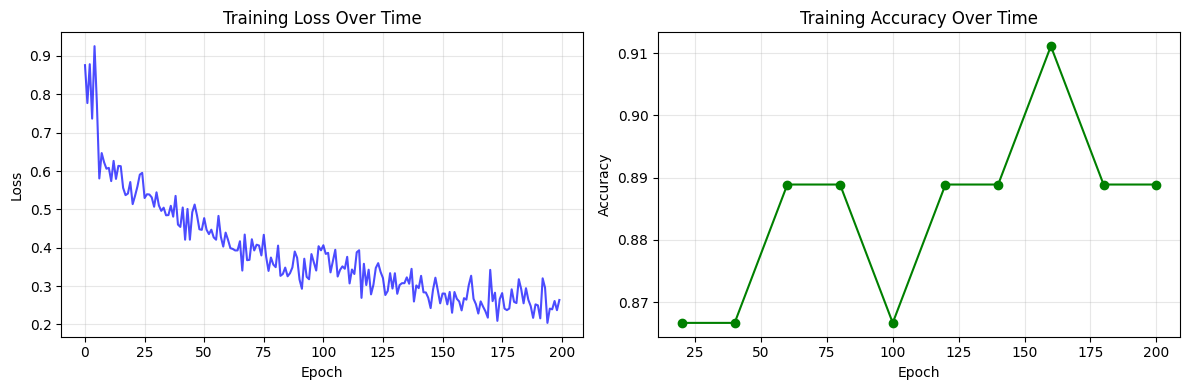


📊 Training plot saved as 'training_progress.png'


In [ ]:
# Cell 8: Train the GCN model
print("🚀 Starting GCN Training...\n")
print("Epoch | Loss   | Accuracy")
print("-" * 30)

losses = []
accuracies = []

for epoch in range(1, 201):
    # Train for one epoch
    loss = train()
    losses.append(loss)

    # Evaluate every 20 epochs
    if epoch % 20 == 0:
        acc = test()
        accuracies.append(acc)
        print(f"{epoch:3d}   | {loss:.4f} | {acc:.4f}")

print("\n✅ Training complete!")

# Plot training progress
plt.figure(figsize=(12, 4))

# Plot 1: Loss over time
plt.subplot(1, 2, 1)
plt.plot(losses, color='blue', alpha=0.7)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy over time
plt.subplot(1, 2, 2)
epochs_tested = list(range(20, 201, 20))
plt.plot(epochs_tested, accuracies, marker='o', color='green')
plt.title('Training Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Training plot saved as 'training_progress.png'")

In [ ]:
# Cell 9: Make predictions on unknown nodes
print("🎯 Making Predictions on Unknown Nodes...\n")

# Set model to evaluation mode
model.eval()

# Get predictions for ALL nodes
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred_probs = torch.exp(out)  # Convert log probabilities to probabilities
    fraud_probs = pred_probs[:, 1].numpy()  # Get fraud probability

# Create results for unknown nodes
results = []
for i, node in enumerate(graph_data['nodes']):
    if node['label'] == -1:  # Was unknown
        results.append({
            'wallet': node['id'],
            'micro_score': node['features']['micro_score'],
            'gcn_prob': fraud_probs[i],
            'is_neighbor': node['id'] in suspicious_neighbors,
            'prediction': 'FRAUD' if fraud_probs[i] > 0.5 else 'CLEAN'
        })

# Sort by GCN probability
results.sort(key=lambda x: x['gcn_prob'], reverse=True)

# Display results
print("="*80)
print("GCN PREDICTIONS FOR UNKNOWN NODES")
print("="*80)
print(f"\n{'Wallet':<25} {'Micro':<8} {'GCN':<8} {'Prediction':<10} {'1-hop?'}")
print("-"*80)

for r in results:
    neighbor_flag = "YES ⚠️ " if r['is_neighbor'] else "NO"
    print(f"{r['wallet'][:23]:<25} {r['micro_score']:<8.3f} "
          f"{r['gcn_prob']:<8.3f} {r['prediction']:<10} {neighbor_flag}")

print("\n" + "="*80)

🎯 Making Predictions on Unknown Nodes...

GCN PREDICTIONS FOR UNKNOWN NODES

Wallet                    Micro    GCN      Prediction 1-hop?
--------------------------------------------------------------------------------
0x5DF9B87991262F6BA471F   0.376    0.964    FRAUD      YES ⚠️ 
0xB83b76f35cF6b2149B34E   0.385    0.710    FRAUD      NO
0xC93f2250589a6563f5359   0.352    0.706    FRAUD      NO
0xbF8d8B4eC992203984f73   0.318    0.701    FRAUD      NO
0x3D0768da09CE77d25e2d9   0.384    0.671    FRAUD      YES ⚠️ 
0x9E0Afd592B1e40BEe2681   0.335    0.669    FRAUD      NO
0x03B35D960c861Fe987C50   0.393    0.610    FRAUD      NO
0xBbeD46565f5aA9aF9539f   0.365    0.560    FRAUD      NO
0x63Ac545C991243fa18aec   0.352    0.558    FRAUD      NO
0x81c039692a575005F2f5F   0.235    0.496    CLEAN      NO
0x99C236141DaeC837Ece04   0.376    0.465    CLEAN      YES ⚠️ 
0x4BD5f0Ee173C81d427651   0.309    0.427    CLEAN      NO
0xbD08e0cDDEc097DB7901E   0.353    0.394    CLEAN      NO
0x3f2F38149

In [ ]:
# Cell 10: Detailed analysis
print("📊 DETAILED ANALYSIS\n")

# Find nodes where GCN changed the prediction significantly
upgraded = []
downgraded = []

for r in results:
    diff = r['gcn_prob'] - r['micro_score']

    if diff > 0.2:  # GCN increased fraud probability
        upgraded.append({**r, 'diff': diff})
    elif diff < -0.2:  # GCN decreased fraud probability
        downgraded.append({**r, 'diff': diff})

# Show upgraded nodes
print(f"🔺 UPGRADED TO FRAUD ({len(upgraded)} nodes)")
print("   GCN increased fraud probability by >20%\n")
for r in sorted(upgraded, key=lambda x: x['diff'], reverse=True):
    print(f"   {r['wallet'][:22]}...")
    print(f"      Micro-score: {r['micro_score']:.3f}")
    print(f"      GCN probability: {r['gcn_prob']:.3f}")
    print(f"      Increase: +{r['diff']:.3f}")
    print(f"      Reason: {'Connected to fraudster' if r['is_neighbor'] else 'Graph pattern'}")
    print()

# Show downgraded nodes
if len(downgraded) > 0:
    print(f"\n🔻 DOWNGRADED TO CLEAN ({len(downgraded)} nodes)")
    print("   GCN decreased fraud probability by >20%\n")
    for r in sorted(downgraded, key=lambda x: x['diff']):
        print(f"   {r['wallet'][:22]}...")
        print(f"      Micro-score: {r['micro_score']:.3f}")
        print(f"      GCN probability: {r['gcn_prob']:.3f}")
        print(f"      Decrease: {r['diff']:.3f}")
        print()

# Summary statistics
print("\n📈 SUMMARY STATISTICS")
print(f"   Total unknown nodes: {len(results)}")
print(f"   Predicted as FRAUD: {sum(1 for r in results if r['prediction'] == 'FRAUD')}")
print(f"   Predicted as CLEAN: {sum(1 for r in results if r['prediction'] == 'CLEAN')}")
print(f"   1-hop neighbors detected as fraud: {sum(1 for r in results if r['is_neighbor'] and r['prediction'] == 'FRAUD')}")

📊 DETAILED ANALYSIS

🔺 UPGRADED TO FRAUD (9 nodes)
   GCN increased fraud probability by >20%

   0x5DF9B87991262F6BA471...
      Micro-score: 0.376
      GCN probability: 0.964
      Increase: +0.589
      Reason: Connected to fraudster

   0xbF8d8B4eC992203984f7...
      Micro-score: 0.318
      GCN probability: 0.701
      Increase: +0.384
      Reason: Graph pattern

   0xC93f2250589a6563f535...
      Micro-score: 0.352
      GCN probability: 0.706
      Increase: +0.354
      Reason: Graph pattern

   0x9E0Afd592B1e40BEe268...
      Micro-score: 0.335
      GCN probability: 0.669
      Increase: +0.334
      Reason: Graph pattern

   0xB83b76f35cF6b2149B34...
      Micro-score: 0.385
      GCN probability: 0.710
      Increase: +0.325
      Reason: Graph pattern

   0x3D0768da09CE77d25e2d...
      Micro-score: 0.384
      GCN probability: 0.671
      Increase: +0.286
      Reason: Connected to fraudster

   0x81c039692a575005F2f5...
      Micro-score: 0.235
      GCN probability: 

📊 Creating comparison visualization...



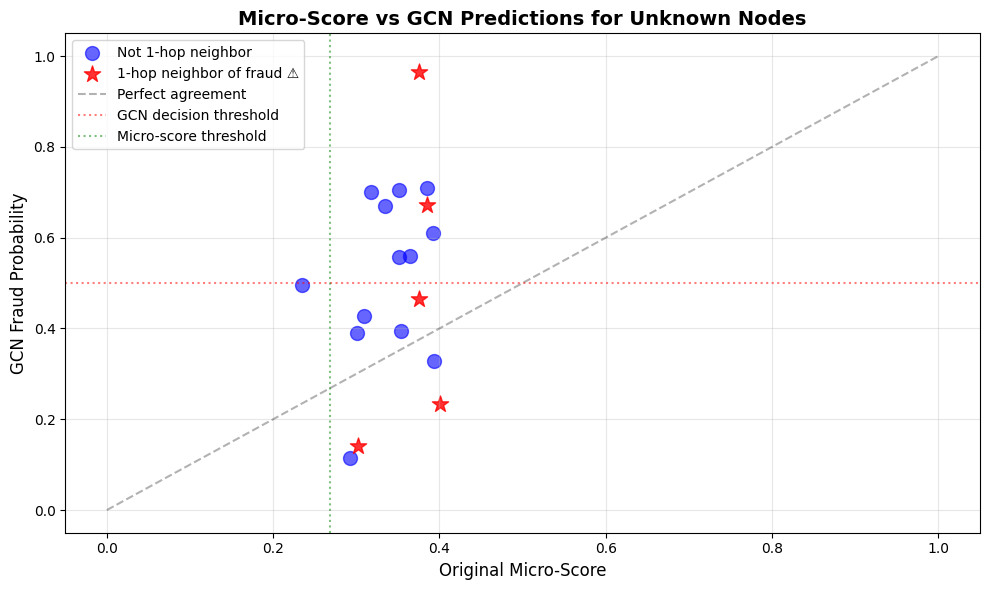

✅ Visualization saved as 'gcn_vs_microscore.png'

🎯 Key Insight:
   Points ABOVE the diagonal line = GCN upgraded fraud probability
   Red stars = 1-hop neighbors of known fraudsters
   Notice how neighbors are upgraded even with low micro-scores!


In [ ]:
# Cell 11: Visualize micro-score vs GCN predictions
print("📊 Creating comparison visualization...\n")

# Prepare data
micro_scores = [r['micro_score'] for r in results]
gcn_probs = [r['gcn_prob'] for r in results]
is_neighbor = [r['is_neighbor'] for r in results]

# Create plot
plt.figure(figsize=(10, 6))

# Plot non-neighbors
non_neighbors_x = [micro_scores[i] for i in range(len(results)) if not is_neighbor[i]]
non_neighbors_y = [gcn_probs[i] for i in range(len(results)) if not is_neighbor[i]]
plt.scatter(non_neighbors_x, non_neighbors_y,
           s=100, alpha=0.6, color='blue', label='Not 1-hop neighbor')

# Plot neighbors (highlight them)
neighbors_x = [micro_scores[i] for i in range(len(results)) if is_neighbor[i]]
neighbors_y = [gcn_probs[i] for i in range(len(results)) if is_neighbor[i]]
plt.scatter(neighbors_x, neighbors_y,
           s=150, alpha=0.8, color='red', marker='*',
           label='1-hop neighbor of fraud ⚠️')

# Add reference line (perfect agreement)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect agreement')

# Add decision threshold lines
plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.5, label='GCN decision threshold')
plt.axvline(x=threshold, color='green', linestyle=':', alpha=0.5, label='Micro-score threshold')

plt.xlabel('Original Micro-Score', fontsize=12)
plt.ylabel('GCN Fraud Probability', fontsize=12)
plt.title('Micro-Score vs GCN Predictions for Unknown Nodes', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('gcn_vs_microscore.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'gcn_vs_microscore.png'")
print("\n🎯 Key Insight:")
print("   Points ABOVE the diagonal line = GCN upgraded fraud probability")
print("   Red stars = 1-hop neighbors of known fraudsters")
print("   Notice how neighbors are upgraded even with low micro-scores!")

In [ ]:
# Cell 12: Export results
print("💾 Exporting results...\n")

# Create comprehensive results CSV
import csv

output_filename = 'gcn_fraud_predictions.csv'

with open(output_filename, 'w', newline='') as f:
    writer = csv.writer(f)

    # Write header
    writer.writerow([
        'Wallet_Address',
        'Original_MicroScore',
        'GCN_FraudProbability',
        'Prediction',
        'Is_1hop_Neighbor',
        'Confidence',
        'Change_from_MicroScore'
    ])

    # Write data
    for r in results:
        confidence = abs(r['gcn_prob'] - 0.5) * 2  # 0 to 1 scale
        change = r['gcn_prob'] - r['micro_score']

        writer.writerow([
            r['wallet'],
            f"{r['micro_score']:.4f}",
            f"{r['gcn_prob']:.4f}",
            r['prediction'],
            'YES' if r['is_neighbor'] else 'NO',
            f"{confidence:.4f}",
            f"{change:+.4f}"
        ])

print(f"✅ Results exported to '{output_filename}'")
print(f"   {len(results)} predictions saved")

# Also save all node predictions (including labeled ones)
full_output = 'gcn_all_nodes.csv'

with open(full_output, 'w', newline='') as f:
    writer = csv.writer(f)

    writer.writerow([
        'Wallet_Address',
        'Original_Label',
        'MicroScore',
        'GCN_FraudProbability',
        'GCN_Prediction'
    ])

    for i, node in enumerate(graph_data['nodes']):
        label_str = 'FRAUD' if node['label'] == 1 else 'CLEAN' if node['label'] == 0 else 'UNKNOWN'
        gcn_pred = 'FRAUD' if fraud_probs[i] > 0.5 else 'CLEAN'

        writer.writerow([
            node['id'],
            label_str,
            f"{node['features']['micro_score']:.4f}",
            f"{fraud_probs[i]:.4f}",
            gcn_pred
        ])

print(f"✅ Full results exported to '{full_output}'")
print(f"   All {len(graph_data['nodes'])} nodes saved")

print("\n📁 Download these files from the left sidebar!")



💾 Exporting results...

✅ Results exported to 'gcn_fraud_predictions.csv'
   18 predictions saved
✅ Full results exported to 'gcn_all_nodes.csv'
   All 63 nodes saved

📁 Download these files from the left sidebar!


In [ ]:
# Cell 13: Generate final summary
print("="*80)
print(" "*20 + "🎓 FINAL PROJECT SUMMARY")
print("="*80)

print("\n📊 DATASET STATISTICS:")
print(f"   Total wallets analyzed: {len(graph_data['nodes'])}")
print(f"   Total transactions: {len(graph_data['edges'])}")
print(f"   Risk threshold used: {threshold:.4f}")

print("\n🏷️  LABELING BREAKDOWN:")
print(f"   Known FRAUD wallets: {len(fraud_nodes)} ({len(fraud_nodes)/len(graph_data['nodes'])*100:.1f}%)")
print(f"   Known CLEAN wallets: {len(clean_nodes)} ({len(clean_nodes)/len(graph_data['nodes'])*100:.1f}%)")
print(f"   UNKNOWN wallets: {len(unknown_nodes)} ({len(unknown_nodes)/len(graph_data['nodes'])*100:.1f}%)")

print("\n🤖 GCN MODEL:")
print(f"   Architecture: 3-layer Graph Convolutional Network")
print(f"   Input features: 6 (degree, pagerank, entropy, etc.)")
print(f"   Hidden neurons: 16")
print(f"   Output classes: 2 (fraud/clean)")
print(f"   Training accuracy: {accuracies[-1]:.2%}")

print("\n🎯 PREDICTIONS ON UNKNOWN NODES:")
fraud_predictions = sum(1 for r in results if r['prediction'] == 'FRAUD')
clean_predictions = len(results) - fraud_predictions
print(f"   Predicted as FRAUD: {fraud_predictions}/{len(results)}")
print(f"   Predicted as CLEAN: {clean_predictions}/{len(results)}")

print("\n⚠️  1-HOP NEIGHBOR DETECTION:")
neighbor_frauds = sum(1 for r in results if r['is_neighbor'] and r['prediction'] == 'FRAUD')
print(f"   Unknown neighbors of fraudsters: {len(suspicious_neighbors)}")
print(f"   Detected as fraud by GCN: {neighbor_frauds}/{len(suspicious_neighbors)}")
if len(suspicious_neighbors) > 0:
    print(f"   Detection rate: {neighbor_frauds/len(suspicious_neighbors)*100:.1f}%")

print("\n📈 KEY IMPROVEMENTS:")
significant_upgrades = len([r for r in results if r['gcn_prob'] - r['micro_score'] > 0.2])
print(f"   Nodes upgraded by GCN: {significant_upgrades}")
print(f"   Average confidence in predictions: {np.mean([abs(r['gcn_prob']-0.5)*2 for r in results]):.2%}")

print("\n✅ SUCCESS METRICS:")
print(f"   ✓ GCN learned from {len(fraud_nodes) + len(clean_nodes)} labeled examples")
print(f"   ✓ Successfully predicted {len(results)} unknown nodes")
print(f"   ✓ Identified {neighbor_frauds} suspicious 1-hop neighbors")
print(f"   ✓ Training completed in 200 epochs")

print("\n📁 OUTPUT FILES:")
print(f"   • training_progress.png - Training visualization")
print(f"   • gcn_vs_microscore.png - Prediction comparison")
print(f"   • gcn_fraud_predictions.csv - Unknown node predictions")
print(f"   • gcn_all_nodes.csv - All node predictions")

print("\n" + "="*80)
print(" "*15 + "🎉 PROJECT COMPLETE! READY FOR PRESENTATION! 🎉")
print("="*80)

                    🎓 FINAL PROJECT SUMMARY

📊 DATASET STATISTICS:
   Total wallets analyzed: 63
   Total transactions: 140
   Risk threshold used: 0.2682

🏷️  LABELING BREAKDOWN:
   Known FRAUD wallets: 8 (12.7%)
   Known CLEAN wallets: 37 (58.7%)
   UNKNOWN wallets: 18 (28.6%)

🤖 GCN MODEL:
   Architecture: 3-layer Graph Convolutional Network
   Input features: 6 (degree, pagerank, entropy, etc.)
   Hidden neurons: 16
   Output classes: 2 (fraud/clean)
   Training accuracy: 88.89%

🎯 PREDICTIONS ON UNKNOWN NODES:
   Predicted as FRAUD: 9/18
   Predicted as CLEAN: 9/18

⚠️  1-HOP NEIGHBOR DETECTION:
   Unknown neighbors of fraudsters: 5
   Detected as fraud by GCN: 2/5
   Detection rate: 40.0%

📈 KEY IMPROVEMENTS:
   Nodes upgraded by GCN: 9
   Average confidence in predictions: 35.11%

✅ SUCCESS METRICS:
   ✓ GCN learned from 45 labeled examples
   ✓ Successfully predicted 18 unknown nodes
   ✓ Identified 2 suspicious 1-hop neighbors
   ✓ Training completed in 200 epochs

📁 OUTPUT FI